 <img width="200" style="float:left" 
     src="https://upload.wikimedia.org/wikipedia/commons/f/f3/Apache_Spark_logo.svg" />

 <img width="200" style="float:left" 
     src="https://storage.googleapis.com/kaggle-datasets-images/1546318/2549419/519ae15c262818cdd94fa315325858aa/dataset-cover.png?t=2021-08-22-18-33-50" />

<a id='1'></a>
## 1. Setup

Since we are going to process data stored from HDFS let's start the service

<a id='1.1'></a>
### 1.1 Start Hadoop

Start Hadoop

Open a terminal and execute
```sh
hadoop-start.sh
```

<a id='1.2'></a>
### 1.2 Search for Spark Installation 
This step is required just because we are working in the course environment.


In [2]:
import findspark
findspark.init()

In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

<a id='1.3'></a>
### 1.3 Create SparkSession

Let's create the SparkSession in first place:<br/>

In [4]:
from pyspark.sql.session import SparkSession

spark = (SparkSession.builder
    .appName("marketing_campaign")
    .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


<a id='2'></a>
## 2. Lab

In [5]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

<a id='2.1'></a>
### 2.1 Check Kaggle Files

In order to complete this lab you need to previosly upload the marketing_campaign from Kaggle into HDFS.<br/>

Check you have the data ready in HDFS

http://localhost:50070/explorer.html#/datalake/raw/iris/

In [6]:
marketingDF = (spark.read.option("header","true")
                 .option("inferSchema","true")
                 .option("delimiter","\t")
                 .csv("hdfs://localhost:9000/datalake/raw/marketing_campaign.csv")
                 .cache())

print(f"There are {marketingDF.count()} rows in the datasets")


There are 2240 rows in the datasets


In [7]:
marketingDF.show()

+----+----------+----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+-------------+---------+--------+
|  ID|Year_Birth| Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Z_CostContact|Z_Revenue|Response|
+----+----------+----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+----------

In [8]:
#which are the columns 
marketingDF.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Year_Birth: integer (nullable = true)
 |-- Education: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Kidhome: integer (nullable = true)
 |-- Teenhome: integer (nullable = true)
 |-- Dt_Customer: string (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- MntWines: integer (nullable = true)
 |-- MntFruits: integer (nullable = true)
 |-- MntMeatProducts: integer (nullable = true)
 |-- MntFishProducts: integer (nullable = true)
 |-- MntSweetProducts: integer (nullable = true)
 |-- MntGoldProds: integer (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebPurchases: integer (nullable = true)
 |-- NumCatalogPurchases: integer (nullable = true)
 |-- NumStorePurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- AcceptedCmp3: integer (nullable = true)
 |-- AcceptedCmp4: integer (nullable = true)
 |-- AcceptedC



## Attributes

### People

- **ID**: Customer's unique identifier
- **Year_Birth**: Customer's birth year
- **Education**: Customer's education level
- **Marital_Status**: Customer's marital status
- **Income**: Customer's yearly household income
- **Kidhome**: Number of children in customer's household
- **Teenhome**: Number of teenagers in customer's household
- **Dt_Customer**: Date of customer's enrollment with the company
- **Recency**: Number of days since the customer's last purchase
- **Complain**: 1 if the customer complained in the last 2 years, 0 otherwise

### Products

- **MntWines**: Amount spent on wine in the last 2 years
- **MntFruits**: Amount spent on fruits in the last 2 years
- **MntMeatProducts**: Amount spent on meat in the last 2 years
- **MntFishProducts**: Amount spent on fish in the last 2 years
- **MntSweetProducts**: Amount spent on sweets in the last 2 years
- **MntGoldProds**: Amount spent on gold in the last 2 years

### Promotion

- **NumDealsPurchases**: Number of purchases made with a discount
- **AcceptedCmp1**: 1 if the customer accepted the offer in the 1st campaign, 0 otherwise
- **AcceptedCmp2**: 1 if the customer accepted the offer in the 2nd campaign, 0 otherwise
- **AcceptedCmp3**: 1 if the customer accepted the offer in the 3rd campaign, 0 otherwise
- **AcceptedCmp4**: 1 if the customer accepted the offer in the 4th campaign, 0 otherwise
- **AcceptedCmp5**: 1 if the customer accepted the offer in the 5th campaign, 0 otherwise
- **Response**: 1 if the customer accepted the offer in the last campaign, 0 otherwise

### Place

- **NumWebPurchases**: Number of purchases made through the company’s website
- **NumCatalogPurchases**: Number of purchases made using a catalogue
- **NumStorePurchases**: Number of purchases made directly in stores
- **NumWebVisitsMonth**: Number of visits to the company’s website in the last month

In [9]:
marketingDF.describe().show()

+-------+------------------+------------------+---------+--------------+------------------+-------------------+------------------+-----------+-----------------+------------------+------------------+-----------------+------------------+-----------------+----------------+-----------------+------------------+-------------------+-----------------+-----------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------+---------+-------------------+
|summary|                ID|        Year_Birth|Education|Marital_Status|            Income|            Kidhome|          Teenhome|Dt_Customer|          Recency|          MntWines|         MntFruits|  MntMeatProducts|   MntFishProducts| MntSweetProducts|    MntGoldProds|NumDealsPurchases|   NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|       AcceptedCmp3|       AcceptedCmp4|       AcceptedCmp5|       AcceptedCmp1|        AcceptedCmp2|       

In [10]:
from pyspark.sql.functions import col, isnan, when, count

In [11]:
# Count missing values
missing_data = marketingDF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in marketingDF.columns])
missing_data.show()

+---+----------+---------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+-------------+---------+--------+
| ID|Year_Birth|Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Z_CostContact|Z_Revenue|Response|
+---+----------+---------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+---

Income has 24 missing values, rest none

# DATA CLEANING

In [12]:
#remove rows with missing values
marketingDF = marketingDF.na.drop()

In [13]:
marketingDF.count()

2216

In [14]:
from pyspark.sql.functions import to_date
marketingDF = marketingDF.withColumn('Dt_Customer', to_date(marketingDF['Dt_Customer'], 'dd-MM-yyyy'))

In [15]:
marketingDF.show()

+----+----------+----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+-------------+---------+--------+
|  ID|Year_Birth| Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Z_CostContact|Z_Revenue|Response|
+----+----------+----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+----------

In [16]:
from pyspark.sql.functions import to_date, max as max_, min as min_


In [17]:
df = marketingDF.toPandas()

In [18]:
# Find the newest and oldest customer enrolment dates
max_date = marketingDF.agg(max_('Dt_Customer')).collect()[0][0]
min_date = marketingDF.agg(min_('Dt_Customer')).collect()[0][0]

print(f"The newest customer's enrolment date in the records: {max_date}")
print(f"The oldest customer's enrolment date in the records: {min_date}")

The newest customer's enrolment date in the records: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


In [19]:
from pyspark.sql.functions import to_date, max as max_, datediff, lit


# Find the last recorded date in the dataset
last_date = marketingDF.agg(max_('Dt_Customer')).collect()[0][0]

# Create the 'Customer_For' feature as the number of days relative to the last recorded date
marketingDF = marketingDF.withColumn('Customer_For', datediff(lit(last_date), 'Dt_Customer'))

# Show the result
marketingDF.select('Dt_Customer', 'Customer_For').show()

+-----------+------------+
|Dt_Customer|Customer_For|
+-----------+------------+
| 2012-09-04|         663|
| 2014-03-08|         113|
| 2013-08-21|         312|
| 2014-02-10|         139|
| 2014-01-19|         161|
| 2013-09-09|         293|
| 2012-11-13|         593|
| 2013-05-08|         417|
| 2013-06-06|         388|
| 2014-03-13|         108|
| 2012-11-13|         593|
| 2013-11-15|         226|
| 2013-11-15|         226|
| 2012-10-10|         627|
| 2012-11-24|         582|
| 2012-12-24|         552|
| 2012-08-31|         667|
| 2013-03-28|         458|
| 2012-11-03|         603|
| 2012-08-08|         690|
+-----------+------------+
only showing top 20 rows



In [20]:
# Calculate value counts for Marital_Status
marital_status_counts = marketingDF.groupBy("Marital_Status").count().orderBy("count", ascending=False)

# Calculate value counts for Education
education_counts = marketingDF.groupBy("Education").count().orderBy("count", ascending=False)

# Show the results
print("Total categories in the feature Marital_Status:")
marital_status_counts.show()

print("Total categories in the feature Education:")
education_counts.show()

Total categories in the feature Marital_Status:
+--------------+-----+
|Marital_Status|count|
+--------------+-----+
|       Married|  857|
|      Together|  573|
|        Single|  471|
|      Divorced|  232|
|         Widow|   76|
|         Alone|    3|
|          YOLO|    2|
|        Absurd|    2|
+--------------+-----+

Total categories in the feature Education:
+----------+-----+
| Education|count|
+----------+-----+
|Graduation| 1116|
|       PhD|  481|
|    Master|  365|
|  2n Cycle|  200|
|     Basic|   54|
+----------+-----+



# Feature Engineering

- Extract "Age" from "Year_Birth".
- Calculate total "Spent" over two years.
- Derive "Living_With" from "Marital_Status".
- Count "Children" for kids and teenagers.
- Define "Family_Size" for household clarity.
- Indicate "Is_Parent" status.
- Simplify "Education" into three categories.
- Drop redundant features.


In [21]:
# Age of customer today
current_year = lit(2023)
marketingDF = marketingDF.withColumn("Age", current_year - col("Year_Birth"))

In [22]:
# Total spendings on various items
spending_columns = ["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]
marketingDF = marketingDF.withColumn("Spent", sum(col(c) for c in spending_columns))

In [23]:
# First, create the Living_With column with a default value
marketingDF = marketingDF.withColumn("Living_With", col("Marital_Status"))

# Then, apply the replacement logic
replacement_dict = {"Married": "Partner", "Together": "Partner", "Absurd": "Alone", 
                    "Widow": "Alone", "YOLO": "Alone", "Divorced": "Alone", "Single": "Alone"}
for original, replacement in replacement_dict.items():
    marketingDF = marketingDF.withColumn("Living_With", 
                                         when(col("Marital_Status") == original, replacement)
                                         .otherwise(col("Living_With")))


In [24]:

# Feature indicating total children living in the household
marketingDF = marketingDF.withColumn("Children", col("Kidhome") + col("Teenhome"))

In [25]:

# Feature for total members in the household
marketingDF = marketingDF.withColumn("Family_Size", when(col("Living_With") == "Alone", lit(1)).when(col("Living_With") == "Partner", lit(2)) + col("Children"))

In [26]:
# Feature pertaining to parenthood
marketingDF = marketingDF.withColumn("Is_Parent", when(col("Children") > 0, lit(1)).otherwise(lit(0)))

In [27]:
# Segmenting education levels into three groups
education_replacement_dict = {"Basic":"Undergraduate", "2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"}
for original, replacement in education_replacement_dict.items():
    marketingDF = marketingDF.withColumn("Education", when(col("Education") == original, lit(replacement)).otherwise(col("Education")))

In [28]:
# Rename columns for clarity
rename_dict = {"MntWines": "Wines", "MntFruits": "Fruits", "MntMeatProducts": "Meat", "MntFishProducts": "Fish", "MntSweetProducts": "Sweets", "MntGoldProds": "Gold"}
for original, new in rename_dict.items():
    marketingDF = marketingDF.withColumnRenamed(original, new)

In [29]:
# Dropping some of the redundant features
columns_to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
marketingDF = marketingDF.drop(*columns_to_drop)

In [30]:
# Show the result
marketingDF.printSchema()
marketingDF.show()

root
 |-- Education: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Kidhome: integer (nullable = true)
 |-- Teenhome: integer (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- Wines: integer (nullable = true)
 |-- Fruits: integer (nullable = true)
 |-- Meat: integer (nullable = true)
 |-- Fish: integer (nullable = true)
 |-- Sweets: integer (nullable = true)
 |-- Gold: integer (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebPurchases: integer (nullable = true)
 |-- NumCatalogPurchases: integer (nullable = true)
 |-- NumStorePurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- AcceptedCmp3: integer (nullable = true)
 |-- AcceptedCmp4: integer (nullable = true)
 |-- AcceptedCmp5: integer (nullable = true)
 |-- AcceptedCmp1: integer (nullable = true)
 |-- AcceptedCmp2: integer (nullable = true)
 |-- Complain: integer (nullable = true)
 |-- Response: integer (nullable = true)
 |-- Custo

In [31]:
marketingDF.describe().show()

+-------+-------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-------------------+-----------------+-----------------+-------------------+------------------+-------------------+-------------------+--------------------+-------------------+-------------------+------------------+------------------+-----------------+-----------+------------------+------------------+-------------------+
|summary|    Education|            Income|           Kidhome|          Teenhome|          Recency|             Wines|            Fruits|              Meat|             Fish|            Sweets|             Gold| NumDealsPurchases|   NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|       AcceptedCmp3|      AcceptedCmp4|       AcceptedCmp5|       AcceptedCmp1|        AcceptedCmp2|           Complain|     

- Discrepancies noted in mean and max Income and Age.
- Max age recorded at 128 years, calculated as of 2023, indicating dated data.
- A broader data review is planned through feature plotting.


Relative Plot Of Some Selected Features: A Data Subset


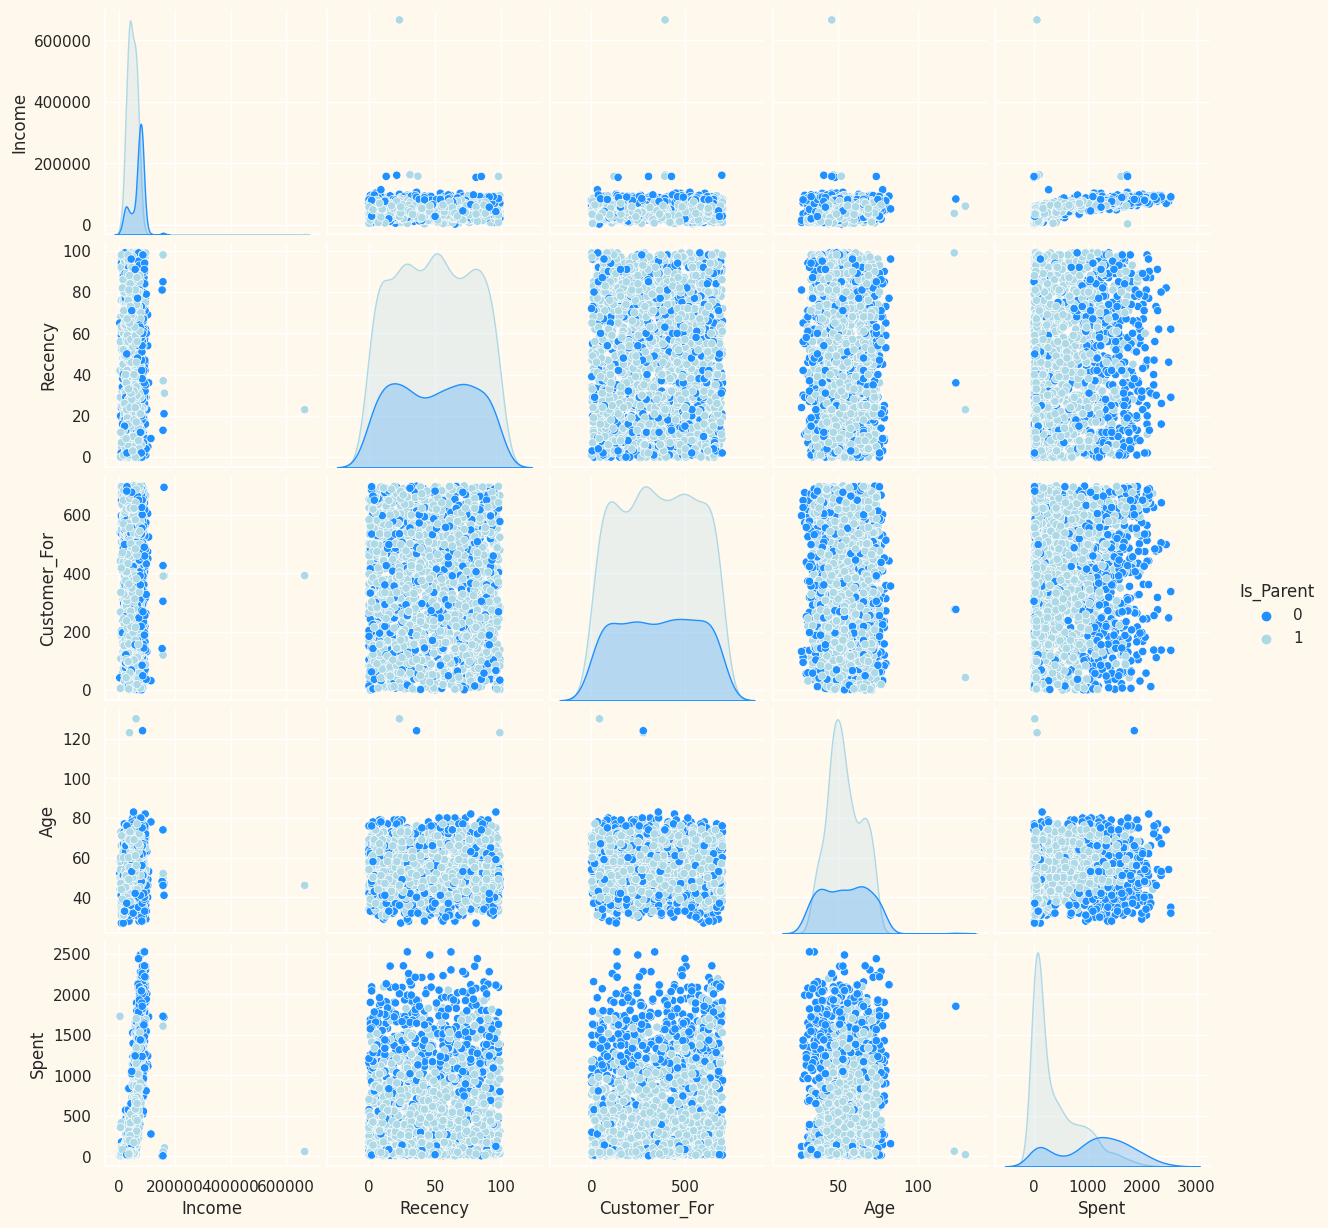

In [32]:
pandas_df = marketingDF.select("Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent").toPandas()

# Now you can plot using seaborn and matplotlib as you would normally do with a Pandas DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors

# New color palette and colormap with shades of blue
pallet = ["#1E90FF", "#4169E1", "#6495ED", "#87CEEB", "#ADD8E6", "#B0E0E6"]
cmap = colors.ListedColormap(pallet)

# Setting up colors preferences with the new palette
sns.set(rc={"axes.facecolor":"#FFF8ED", "figure.facecolor":"#FFF8ED"})

# Plotting selected features
to_plot = ["Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Relative Plot Of Some Selected Features: A Data Subset")
sns.pairplot(pandas_df[to_plot], hue="Is_Parent", palette=("#1E90FF", "#ADD8E6"))

# Showing the plot
plt.show()

Clearly, there are a few outliers in the Income and Age features. I will be deleting the outliers in the data.



In [33]:
# Drop outliers by filtering on Age and Income
marketingDF = marketingDF.filter(marketingDF["Age"] < 90).filter(marketingDF["Income"] < 600000)

# Print the number of data points after removing outliers
print("The total number of data-points after removing the outliers are:", marketingDF.count())

The total number of data-points after removing the outliers are: 2212


In [34]:
from pyspark.ml.stat import Correlation 

In [35]:
marketingDF.printSchema()


root
 |-- Education: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Kidhome: integer (nullable = true)
 |-- Teenhome: integer (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- Wines: integer (nullable = true)
 |-- Fruits: integer (nullable = true)
 |-- Meat: integer (nullable = true)
 |-- Fish: integer (nullable = true)
 |-- Sweets: integer (nullable = true)
 |-- Gold: integer (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebPurchases: integer (nullable = true)
 |-- NumCatalogPurchases: integer (nullable = true)
 |-- NumStorePurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- AcceptedCmp3: integer (nullable = true)
 |-- AcceptedCmp4: integer (nullable = true)
 |-- AcceptedCmp5: integer (nullable = true)
 |-- AcceptedCmp1: integer (nullable = true)
 |-- AcceptedCmp2: integer (nullable = true)
 |-- Complain: integer (nullable = true)
 |-- Response: integer (nullable = true)
 |-- Custo

In [36]:
#find all numeric columns pyspark
numeric_features = [t[0] for t in marketingDF.dtypes if t[1] == 'int' or t[1] == 'double']

# Label Encoding

In [37]:
# do label encoding for columns - Education and Living_With in pyspark
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="Living_With", outputCol="Living_With_label") 
indexed_df = indexer.fit(marketingDF).transform(marketingDF)
indexed_df=indexed_df.drop("Living_With").withColumnRenamed("Living_With_label","Living_With")
print("The output dataframe is:")
indexed_df.show()

The output dataframe is:
+-------------+------+-------+--------+-------+-----+------+----+----+------+----+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------+------------+---+-----+--------+-----------+---------+-----------+
|    Education|Income|Kidhome|Teenhome|Recency|Wines|Fruits|Meat|Fish|Sweets|Gold|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Response|Customer_For|Age|Spent|Children|Family_Size|Is_Parent|Living_With|
+-------------+------+-------+--------+-------+-----+------+----+----+------+----+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------+------------+---+-----+--------+-----------+---------+-----------+
|     Gra

In [38]:
# do label encoding for columns - Education and Living_With in pyspark
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="Education", outputCol="Education_label") 
indexed_df2 = indexer.fit(indexed_df).transform(indexed_df)
indexed_df2=indexed_df2.drop("Education").withColumnRenamed("Education_label","Education")
print("The output dataframe is:")
indexed_df2.show()

The output dataframe is:
+------+-------+--------+-------+-----+------+----+----+------+----+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------+------------+---+-----+--------+-----------+---------+-----------+---------+
|Income|Kidhome|Teenhome|Recency|Wines|Fruits|Meat|Fish|Sweets|Gold|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Response|Customer_For|Age|Spent|Children|Family_Size|Is_Parent|Living_With|Education|
+------+-------+--------+-------+-----+------+----+----+------+----+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------+------------+---+-----+--------+-----------+---------+-----------+---------+
| 58138|      0|     

In [39]:
# copy data
df = indexed_df2

In [40]:
# remove AcceptedCmp1, AcceptedCmp2, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, Response, Complain
df = df.drop("AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Response", "Complain")

In [41]:
#check index of columns
df.columns


['Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'Wines',
 'Fruits',
 'Meat',
 'Fish',
 'Sweets',
 'Gold',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'Customer_For',
 'Age',
 'Spent',
 'Children',
 'Family_Size',
 'Is_Parent',
 'Living_With',
 'Education']

In [42]:
#assemble all the features with VectorAssembler
assembler = VectorAssembler(inputCols=['Income','Kidhome', 'Teenhome', 'Recency', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases', 
                                       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Customer_For', 'Age', 'Spent', 
                                       'Children', 'Family_Size', 'Is_Parent', 'Living_With', 'Education'], outputCol="features")

In [43]:
df = assembler.transform(df)


In [44]:
#import standard scaler
from pyspark.ml.feature import StandardScaler

In [45]:
# Create a StandardScaler transformer object
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
df = scaler.fit(df).transform(df)


In [46]:
from pyspark.ml.feature import PCA


In [47]:

pca = PCA(k=3, inputCol="scaled_features", outputCol="pca_features")
df_3d = pca.fit(df).transform(df)


In [48]:
from pyspark.ml.clustering import KMeans


In [49]:

kmeans = KMeans(k=4, seed=221, maxIter=20, featuresCol="pca_features")

model = kmeans.fit(df_3d)


In [50]:
type(model)

pyspark.ml.clustering.KMeansModel

In [51]:
model.summary.clusterSizes

[609, 552, 512, 539]

In [52]:
# Obtain the clusterCenters from the KMeansModel
for center in model.clusterCenters():    
    print(center)

[ 0.96648876 -4.14113021 -0.9796162 ]
[-1.91664218 -7.76965135 -0.80083877]
[-5.23649985 -4.93432097 -0.23720261]
[ 1.52107134 -6.5821081   0.36131407]


In [53]:
# Use the model to transform the DataFrame by adding cluster predictions
predictions = model.transform(df_3d)


In [54]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(featuresCol="scaled_features")

# Evaluate clustering by computing Silhouette score
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette with squared euclidean distance = {silhouette}")

# Evaluate clustering by computing Within Set Sum of Squared Errors.
WSSSE = model.summary.trainingCost
print(f"Within Set Sum of Squared Errors = {WSSSE}")


Silhouette with squared euclidean distance = 0.257886274446046
Within Set Sum of Squared Errors = 7550.4451503696755


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

prediction_with_pca_df = predictions.select((vector_to_array(col('pca_features'))[0]).alias('x'),
                        (vector_to_array(col('pca_features'))[1]).alias('y'),
                        (vector_to_array(col('pca_features'))[2]).alias('z'),
                         col('prediction').alias('label')).toPandas()

In [56]:
prediction_with_pca_df

x         y         z  label
0    -6.038836 -5.663533 -2.881266      2
1     1.819890 -5.847703  1.094035      3
2    -3.668800 -5.093755 -0.172052      2
3     1.600339 -4.369462 -0.038134      0
4    -0.397761 -6.002835 -0.295160      3
...        ...       ...       ...    ...
2207 -3.376048 -8.261926 -0.930023      1
2208  2.046670 -9.838168  0.979424      3
2209 -3.719522 -3.931759 -0.994706      2
2210 -2.540641 -7.476411  1.323551      1
2211  1.679223 -7.512706 -0.224476      3

[2212 rows x 4 columns]

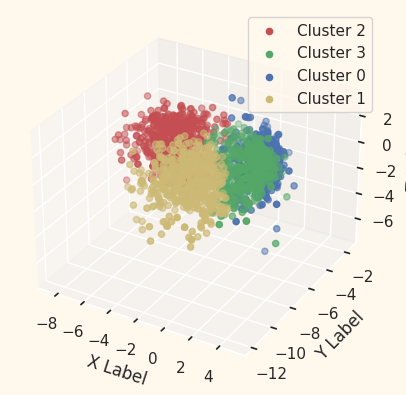

In [57]:
clusters = prediction_with_pca_df['label'].unique()

# Create a figure and 3D axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot data points for each cluster
colors = ['r', 'g', 'b', 'y']  # You can extend this list for more clusters
for i, cluster in enumerate(clusters):
    cluster_data = prediction_with_pca_df[prediction_with_pca_df['label'] == cluster]
    ax.scatter(cluster_data['x'], cluster_data['y'], cluster_data['z'], c=colors[i], label=f'Cluster {cluster}')

# Plot cluster centroids in black
centroids = model.clusterCenters()
for c in centroids:
    ax.scatter(c[0], c[1], c[2], c='black', marker='x', s=100)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.legend()
plt.show()

In [58]:
pip install plotly

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [59]:
import plotly.express as px



clusters = prediction_with_pca_df['label'].unique()

# Create a figure
fig = px.scatter_3d(prediction_with_pca_df, x='x', y='y', z='z', color='label',
                    labels={'x': 'X Label', 'y': 'Y Label', 'z': 'Z Label'},
                    title='3D Scatter Plot of Clusters')

# Add cluster centroids
centroids = model.clusterCenters()
centroid_x, centroid_y, centroid_z = zip(*centroids)
fig.add_scatter3d(x=centroid_x, y=centroid_y, z=centroid_z, mode='markers',
                  marker=dict(size=10, color='black', symbol='cross', line=dict(width=2)),
                  name='Centroids')

# Show the plot
fig.show()


<AxesSubplot: >

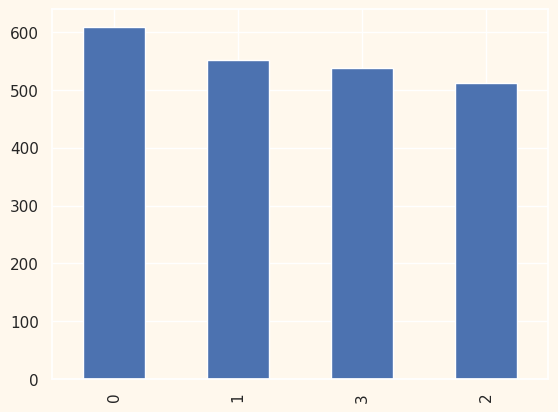

In [60]:
#distribution of clusters
prediction_with_pca_df['label'].value_counts().plot(kind='bar')

In [61]:
predictions.show()

+------+-------+--------+-------+-----+------+----+----+------+----+-----------------+---------------+-------------------+-----------------+-----------------+------------+---+-----+--------+-----------+---------+-----------+---------+--------------------+--------------------+--------------------+----------+
|Income|Kidhome|Teenhome|Recency|Wines|Fruits|Meat|Fish|Sweets|Gold|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|Customer_For|Age|Spent|Children|Family_Size|Is_Parent|Living_With|Education|            features|     scaled_features|        pca_features|prediction|
+------+-------+--------+-------+-----+------+----+----+------+----+-----------------+---------------+-------------------+-----------------+-----------------+------------+---+-----+--------+-----------+---------+-----------+---------+--------------------+--------------------+--------------------+----------+
| 58138|      0|       0|     58|  635|    88| 546| 172|    88|  88|     

In [62]:
predictions_pandas = predictions.toPandas()


# income vs clusters

In [63]:
fig = px.scatter(predictions_pandas, x="Spent", y="Income", color="prediction")

fig.update_layout(
    title="Cluster's Profile Based On Income And Spending"
)

fig.show()

Income vs spending plot shows the clusters pattern

*  group 0: high spending & average income
* group 1: high spending & high income
* group 2: low spending & low income
* group 3: high spending & low income

In [64]:
# Create a swarm plot
fig_swarm = px.scatter(predictions_pandas, x="prediction", y="Spent", color="prediction", title="Swarm Plot", opacity=0.5)

# Create a boxen plot
fig_boxen = px.box(predictions_pandas, x="prediction", y="Spent", title="Boxen Plot", color="prediction")

# Combine the swarm and boxen plots
fig_swarm.update_traces(marker=dict(size=4))  # Adjust the marker size for swarm points
fig_combined = fig_boxen.add_traces(fig_swarm.data)

fig_combined.show()

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3544: UserWarning:

75.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3544: UserWarning:

33.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3544: UserWarning:

16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3544: UserWarning:

69.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3544: UserWarning:

79.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.p

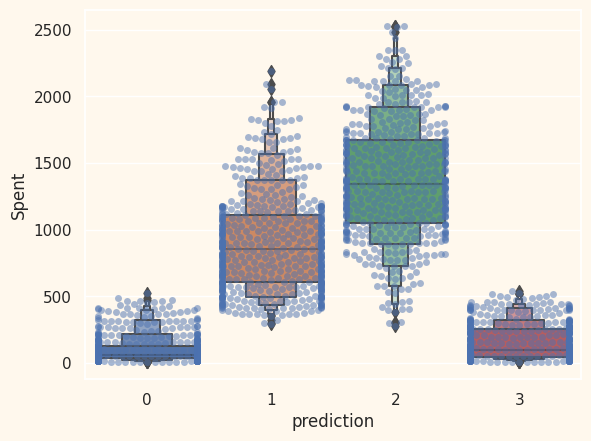

In [65]:
plt.figure()
pl=sns.swarmplot(x=predictions_pandas["prediction"], y=predictions_pandas["Spent"], alpha=0.5 )
pl=sns.boxenplot(x=predictions_pandas["prediction"], y=predictions_pandas["Spent"])
plt.show()

From the above plot, it can be clearly seen that cluster 1 is our biggest set of customers closely followed by cluster 0. We can explore what each cluster is spending on for the targeted marketing strategies.

In [66]:
indexed_df2 = indexed_df2.toPandas()

In [67]:
indexed_df2.columns

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'Wines', 'Fruits', 'Meat',
       'Fish', 'Sweets', 'Gold', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'Customer_For', 'Age', 'Spent',
       'Children', 'Family_Size', 'Is_Parent', 'Living_With', 'Education'],
      dtype='object')

 how did our campaigns do in the past

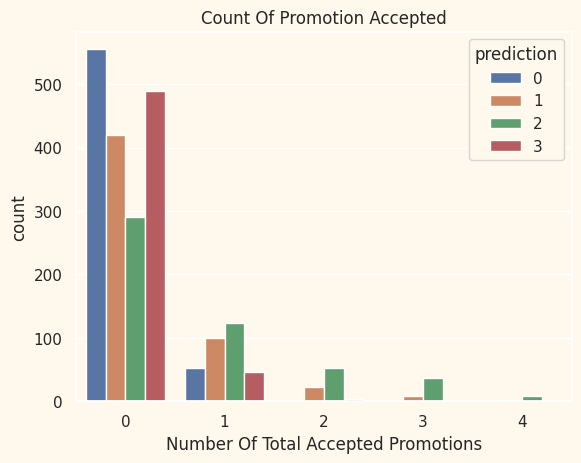

In [68]:
#Creating a feature to get a sum of accepted promotions 
predictions_pandas["Total_Promos"] = indexed_df2["AcceptedCmp1"]+ indexed_df2["AcceptedCmp2"]+ indexed_df2["AcceptedCmp3"]+ indexed_df2["AcceptedCmp4"]+ indexed_df2["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=predictions_pandas["Total_Promos"],hue=predictions_pandas["prediction"])
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

There has not been an overwhelming response to the campaigns so far. Very few participants overall. Moreover, no one part take in all 5 of them. Perhaps better-targeted and well-planned campaigns are required to boost sales.

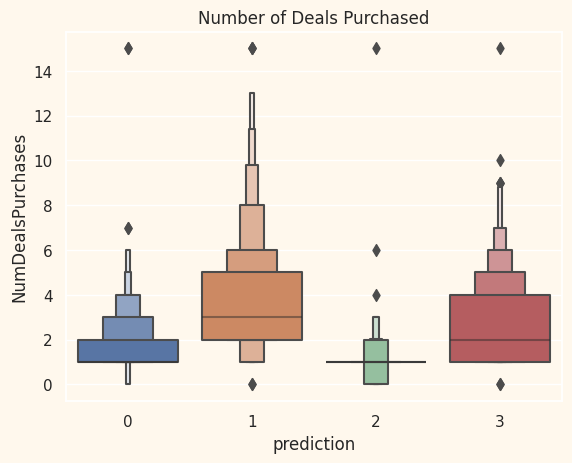

In [69]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=indexed_df2["NumDealsPurchases"],x=predictions_pandas["prediction"])
pl.set_title("Number of Deals Purchased")
plt.show()

Unlike campaigns, the deals offered did well. It has best outcome with cluster 0 and cluster 3. However, our star customers cluster 1 are not much into the deals. Nothing seems to attract cluster 2 overwhelmingly


In [70]:
predictions.show()

+------+-------+--------+-------+-----+------+----+----+------+----+-----------------+---------------+-------------------+-----------------+-----------------+------------+---+-----+--------+-----------+---------+-----------+---------+--------------------+--------------------+--------------------+----------+
|Income|Kidhome|Teenhome|Recency|Wines|Fruits|Meat|Fish|Sweets|Gold|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|Customer_For|Age|Spent|Children|Family_Size|Is_Parent|Living_With|Education|            features|     scaled_features|        pca_features|prediction|
+------+-------+--------+-------+-----+------+----+----+------+----+-----------------+---------------+-------------------+-----------------+-----------------+------------+---+-----+--------+-----------+---------+-----------+---------+--------------------+--------------------+--------------------+----------+
| 58138|      0|       0|     58|  635|    88| 546| 172|    88|  88|     

# Profiling the clusters

In [ ]:
Personal = [ "Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=predictions_pandas[i], y=predictions_pandas["Spent"], hue =predictions_pandas["prediction"], kind="kde")
    plt.show()

In [77]:
#choose 4 colors from the palette

sns.color_palette("husl", 4)

#choose 4 colors from the palett


[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727)]

<Figure size 640x480 with 0 Axes>

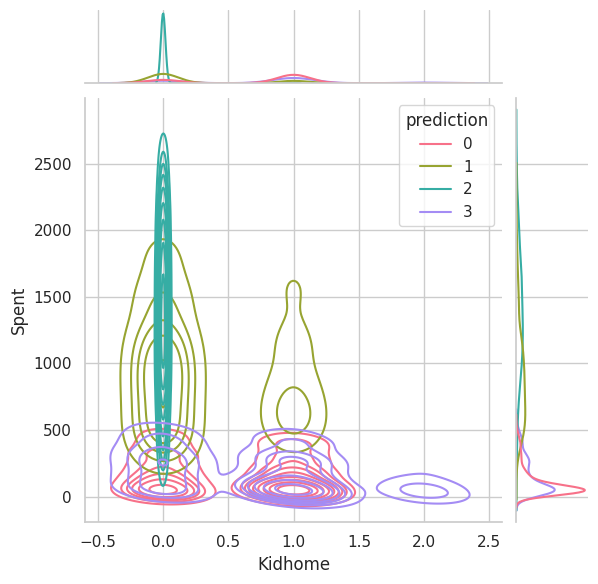

<Figure size 640x480 with 0 Axes>

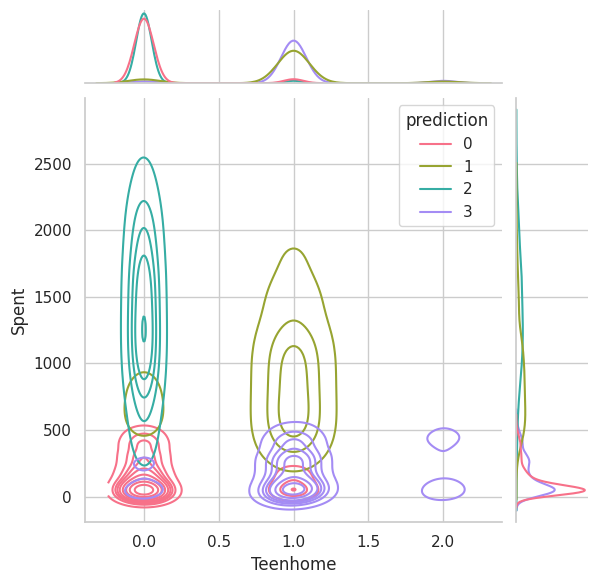

<Figure size 640x480 with 0 Axes>

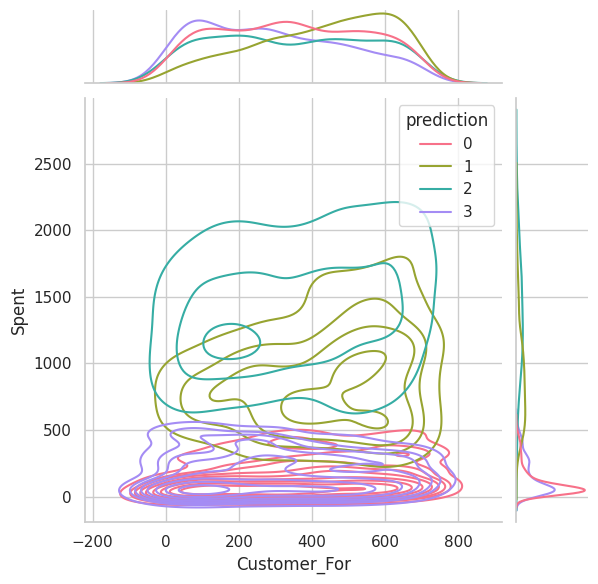

<Figure size 640x480 with 0 Axes>

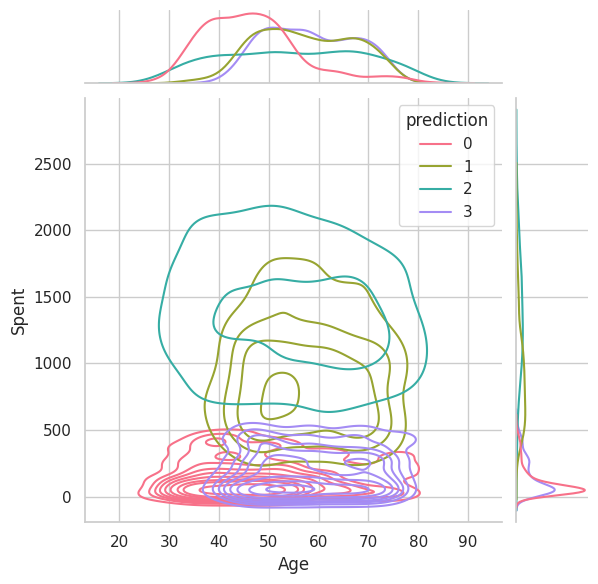

<Figure size 640x480 with 0 Axes>

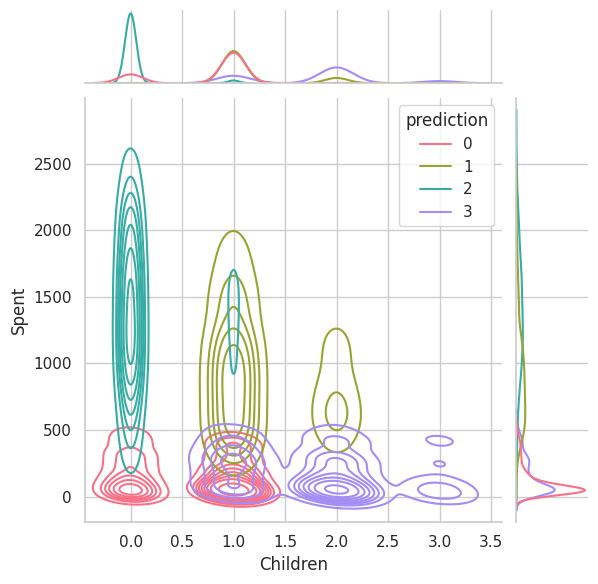

<Figure size 640x480 with 0 Axes>

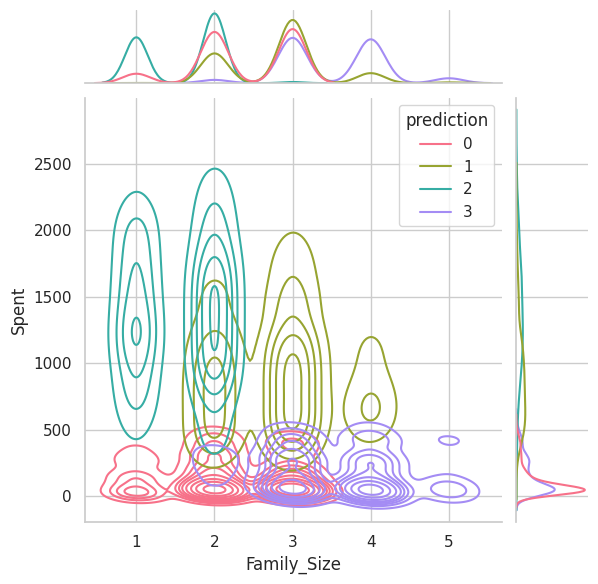

/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:1877: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



<Figure size 640x480 with 0 Axes>

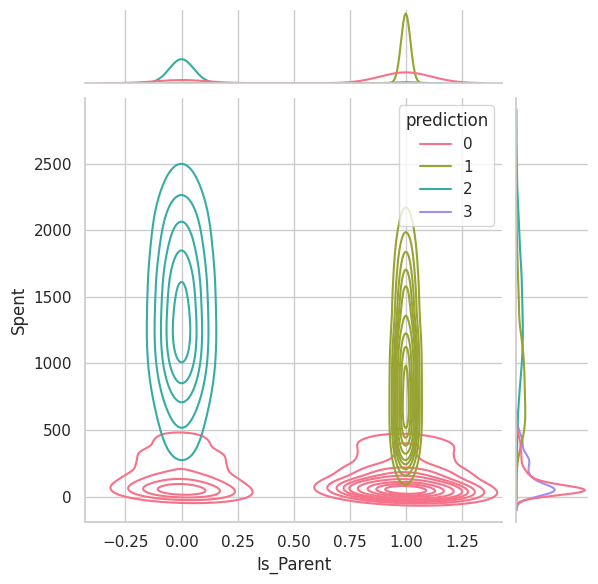

<Figure size 640x480 with 0 Axes>

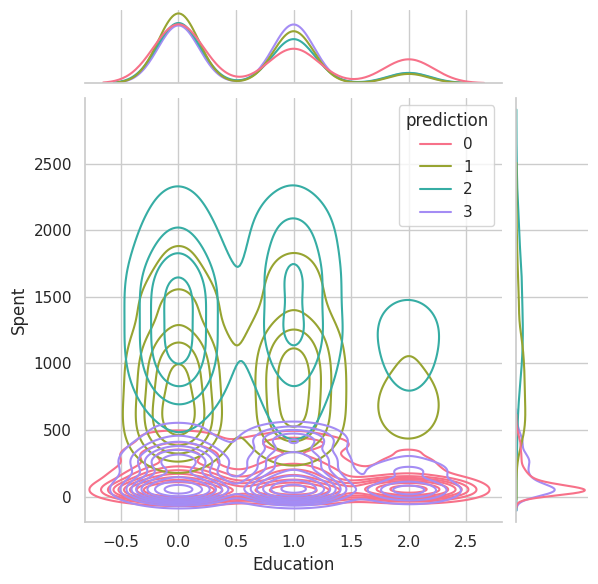

<Figure size 640x480 with 0 Axes>

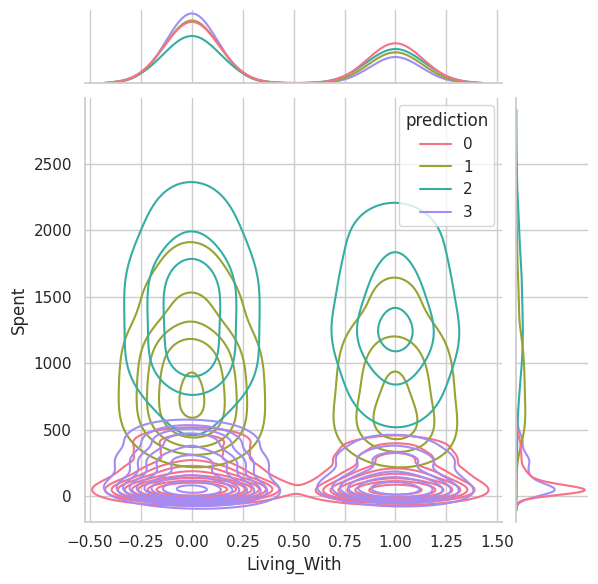

In [78]:
Personal = ["Kidhome", "Teenhome", "Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education", "Living_With"]

# Set the background color
sns.set(style="whitegrid")

# Define a color palette for clusters
cluster_palette = sns.color_palette("husl",4)  # You can choose a different palette if needed

for i in Personal:
    plt.figure()
    sns.set(style="whitegrid")  # Set the background color for each plot
    sns.jointplot(
        x=predictions_pandas[i],
        y=predictions_pandas["Spent"],
        hue=predictions_pandas["prediction"],
        kind="kde",
        palette=cluster_palette,
    )
    plt.show()



Here's how you would generally analyze these cluster graphs:

1. **Identify the Axes**: Each graph has two axes. For example, one graph has 'Kidhome' on the x-axis and 'Spent' on the y-axis. This likely represents the number of children at home compared to the amount spent.

2. **Understand the Clusters**: The color-coded lines represent different clusters. Each cluster will have a center point (in case of k-means) or a range that shows the commonality within that cluster. The distribution and shape of the clusters can indicate how each group behaves. For example, a cluster with a narrow shape along the 'Spent' axis might indicate a group of customers who spend a similar amount consistently.

3. **Interpreting the Overlaps**: Overlapping areas between clusters may indicate customers who share characteristics with more than one segment.

4. **Reading the Marginal Histograms**: The smaller graphs at the top and right margins of each plot show the distribution of each variable (e.g., 'Spent', 'Kidhome') across all clusters. This gives you a sense of the overall data distribution, regardless of the cluster.

5. **Making Business Decisions**: Once you understand the clusters, you can begin to tailor business strategies to each group. For instance, customers in a cluster with a high 'Spent' and low 'Kidhome' might be targeted with high-value product promotions.

6. **Evaluating Cluster Significance**: Evaluate how distinct each cluster is. If clusters are well separated, the characteristics are more pronounced and easier to target. If there's a lot of overlap, the market segments are not very distinct.

7. **Demographic and Behavioral Insights**: You might find correlations between demographic information (like age, number of children) and customer behavior (like spending habits, product preferences).

8. **Predictive Modeling**: Clusters can sometimes be used to predict future buying behavior. For example, if you know a customer is in a cluster that tends to buy organic products, you might recommend those products to them.

9. **Cluster Evolution Over Time**: If this data represents a snapshot in time, it's useful to see how clusters change, which could inform how customer preferences evolve.

10. **Extrapolating to Individual Customers**: Lastly, you can sometimes extrapolate findings from clusters to individual customers if you find particularly strong trends.


 The variables on the x-axes such as 'Kidhome', 'Teenhome', 'Customer_For', 'Age', 'Children', 'Family_Size', 'Is_Parent', 'Education', and 'Living_With' suggest demographic and household characteristics that could influence purchasing behaviors, while the 'Spent' variable on the y-axis represents the amount spent by the customers.

Here's a general approach to defining the clusters:

1. **Cluster 0 (Red)**: This cluster might be characterized by lower values on the x-axis variables and lower 'Spent' values. These could be customers who are younger, possibly singles or couples without children, or with lower educational levels, who tend to spend less on groceries.

2. **Cluster 1 (Green)**: These customers might show moderate to high values on the x-axis variables and a wide range of 'Spent' values. This cluster could represent families with children or older customers who have a varied spending pattern.

3. **Cluster 2 (Blue)**: This group might be distinguished by specific high values on some x-axis variables but lower 'Spent' values. These could be customers with teenagers at home, higher educational levels, or larger family sizes who are perhaps budget-conscious or shop for specific items.

4. **Cluster 3 (Purple)**: Customers in this cluster seem to have high 'Spent' values regardless of the x-axis variables. This cluster might include high-income individuals or those who make substantial purchases, possibly due to high loyalty to the store or a preference for premium products.

Each of these clusters can be further defined by closely examining the distribution and central tendencies of the data within the clusters. For example, if the 'Kidhome' variable shows a cluster centered around a higher number of children at home, it might suggest that these customers are likely to purchase kid-friendly or family-oriented products.

Without the ability to interact with the data directly, I'm providing a high-level interpretation based on standard clustering outcomes. To get a precise definition of each cluster, I would typically analyze the centroid or most representative point of each cluster and consider the spread and density of the data points.

If you require a more detailed and specific analysis, you might need to use data analysis software to inspect the individual data points and statistical summaries for each cluster. If you have any further requests or need assistance with a more detailed analysis based on these images, please let me know.

To interpret and segregate the clusters for each graph, I'll go through them one by one, discussing the general tendencies that can be discerned from the images you've uploaded. However, without interactive capabilities or numerical data, this interpretation will be based on the visual patterns observed. 

1. **Graph with 'Kidhome' on x-axis:**
   - **Cluster 0 (Red):** Low 'Kidhome' values, low 'Spent' values, suggesting these are customers without kids at home who spend less.
   - **Cluster 1 (Green):** Moderate 'Kidhome' values, moderate to high 'Spent' values, indicating these are likely households with children, showing varied spending.
   - **Cluster 2 (Blue):** High 'Kidhome' values, low to moderate 'Spent' values, which could be families with several children, potentially more price-sensitive.
   - **Cluster 3 (Purple):** Low to moderate 'Kidhome' values, very high 'Spent' values, suggesting these customers may have fewer children but spend significantly more, possibly on premium products.

2. **Graph with 'Teenhome' on x-axis:**
   - **Cluster 0 (Red):** Low 'Teenhome' values, low 'Spent' values, possibly indicating younger families or those without teenagers who spend less.
   - **Cluster 1 (Green):** Moderate 'Teenhome' values, a wide range of 'Spent' values, perhaps families with teenagers, showing varied shopping patterns.
   - **Cluster 2 (Blue):** High 'Teenhome' values, generally lower 'Spent' values, could be indicating families with more teenagers who are budget-conscious.
   - **Cluster 3 (Purple):** Moderate 'Teenhome' values, very high 'Spent' values, suggesting these might be affluent families with teenagers.

3. **Graph with 'Customer_For' on x-axis:**
   - **Cluster 0 (Red):** A mix of long-term and new customers with generally low 'Spent' values, indicating a mix of loyalty levels but conservative spending.
   - **Cluster 1 (Green):** Broad range of 'Customer_For' values, moderate 'Spent' values, suggesting a diverse group in terms of customer loyalty.
   - **Cluster 2 (Blue):** Mainly new customers with a wide range of 'Spent' values, indicating varied spending patterns among newer customers.
   - **Cluster 3 (Purple):** A mix of 'Customer_For' values, very high 'Spent' values, which could be less sensitive to how long they have been customers, possibly due to higher disposable income.

4. **Graph with 'Age' on x-axis:**
   - **Cluster 0 (Red):** Younger age range, low 'Spent' values, suggesting these might be younger individuals or young families with limited spending.
   - **Cluster 1 (Green):** Wide age range, moderate to high 'Spent' values, indicating a diverse group in terms of age but more significant spending.
   - **Cluster 2 (Blue):** Middle to older age range, varied 'Spent' values, which could be middle-aged or senior customers with diverse spending habits.
   - **Cluster 3 (Purple):** Broad age range, very high 'Spent' values, suggesting customers in various age groups who tend to spend a lot, potentially more affluent.

5. **Graph with 'Children' on x-axis:**
   - **Cluster 0 (Red):** Low 'Children' values, low 'Spent' values, likely representing individuals or couples without children who spend less.
   - **Cluster 1 (Green):** Moderate 'Children' values, varied 'Spent' values, could be families with children exhibiting a range of spending behaviors.
   - **Cluster 2 (Blue):** Higher 'Children' values, moderate 'Spent' values, potentially larger families with more children, possibly on a budget.
   - **Cluster 3 (Purple):** Low to moderate 'Children' values, very high 'Spent' values, suggesting that families with fewer children are spending more, possibly on higher-quality items.


6. **Graph with 'Family_Size' on x-axis:**
   - **Cluster 0 (Red):** Smaller family sizes, lower 'Spent' values, likely representing singles or small families with conservative shopping habits.
   - **Cluster 1 (Green):** Varied family sizes, a wide range of 'Spent' values, indicating households of different sizes with diverse spending patterns.
   - **Cluster 2 (Blue):** Larger family sizes, moderate 'Spent' values, which could suggest bigger families managing a budget with controlled spending.
   - **Cluster 3 (Purple):** Mid-range family sizes, very high 'Spent' values, possibly affluent nuclear families with the means to spend more on groceries.

7. **Graph with 'Is_Parent' on x-axis:**
   - **Cluster 0 (Red):** Likely non-parents with lower 'Spent' values, representing individuals or couples without children who spend less.
   - **Cluster 1 (Green):** Both parents and non-parents present, with varied 'Spent' values, suggesting a mix of customers with and without children, with no clear spending pattern.
   - **Cluster 2 (Blue):** Mainly parents, with moderate 'Spent' values, which could be families with children shopping with a budget in mind.
   - **Cluster 3 (Purple):** Mainly parents, with very high 'Spent' values, indicating that these parents might be spending considerably more, potentially due to less price sensitivity.

8. **Graph with 'Education' on x-axis:**
   - **Cluster 0 (Red):** Lower educational levels, lower 'Spent' values, suggesting that those with less education might have limited spending power.
   - **Cluster 1 (Green):** Varied educational backgrounds, moderate to high 'Spent' values, indicating that education level does not strongly predict spending behavior in this cluster.
   - **Cluster 2 (Blue):** Higher education levels, moderate 'Spent' values, which might represent well-educated customers who are nonetheless budget-conscious.
   - **Cluster 3 (Purple):** A mix of education levels, very high 'Spent' values, suggesting that within this cluster, spending is less related to educational attainment and more to other factors such as income.

9. **Graph with 'Living_With' on x-axis:**
   - **Cluster 0 (Red):** Lower 'Living_With' values, lower 'Spent' values, possibly indicating singles or those living with fewer people, and who spend less.
   - **Cluster 1 (Green):** Varied 'Living_With' values, a wide range of 'Spent' values, suggesting a mix of living situations with no clear pattern in spending habits.
   - **Cluster 2 (Blue):** Higher 'Living_With' values, moderate 'Spent' values, could represent larger households that are possibly shopping with a budget.
   - **Cluster 3 (Purple):** Mid-range 'Living_With' values, very high 'Spent' values, indicating those living with a few others, but spending significantly, perhaps due to higher disposable income or preferences for premium products.

In each graph, the distribution of points within the clusters can give us an idea of the variance within each group and the degree of overlap between clusters, which could indicate segments of the market that are not distinctly separated. The cluster analysis aims to maximize the similarity within clusters and the difference between clusters to identify distinct customer segments. 

Please note that this interpretation is based on the visual representation of the graphs and would be greatly enhanced by statistical analysis of the underlying data. If you have the data and require more in-depth analysis or have specific questions about these interpretations, please let me know.


**Cluster 0 (Red): Low Spend, Low Dependents/Commitments**
- Characteristics: This cluster typically represents individuals or small families with fewer dependents, such as children or teenagers. They may include younger customers, single adults, or couples without children.
- Behavior: These customers tend to spend less on groceries, which could be due to lower disposable income or fewer household members to provide for. They may prioritize essential purchases or budget items over premium products.

**Cluster 1 (Green): Moderate to High Spend, Mixed Dependents/Commitments**
- Characteristics: Cluster 1 is a diverse segment that includes customers with varying family sizes and living situations. It may comprise middle-aged adults, mixed households, and families with children or teenagers.
- Behavior: Their spending patterns are varied, with some making moderate purchases and others spending more liberally. This suggests that this group may include both budget-conscious customers and those willing to spend more on groceries when needed.

**Cluster 2 (Blue): Moderate Spend, Larger Families or Higher Commitments**
- Characteristics: This cluster appears to consist of larger families or individuals with higher educational levels or commitments. There may be a higher number of dependents or cohabitants, such as children, teenagers, or extended family members.
- Behavior: Despite the potential for higher spending due to more significant household needs, this group shows moderate expenditure, which could indicate price sensitivity or a focus on value-for-money purchases.

**Cluster 3 (Purple): High Spend, Affluent or Less Price-Sensitive**
- Characteristics: Customers in this cluster may not be defined by a specific demographic such as age or family size, but rather by their high spending behavior.
- Behavior: This suggests a group with higher disposable income or a preference for premium products. They may be less sensitive to price, opting for convenience, quality, or luxury items. These could be long-term, loyal customers or those who make bulk purchases.

In summary:
- **Cluster 0** is likely seeking value and may respond well to promotions and discounts.
- **Cluster 1** is diverse and might require a more segmented marketing approach to cater to the varying needs within this group.
- **Cluster 2** could be targeted with family-sized packages, bulk deals, and educational or back-to-school promotions.
- **Cluster 3** may be interested in premium brands, high-quality products, and could be less responsive to price-based marketing, instead valuing exclusivity or loyalty rewards.
